In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# Define custom loss function L(y_t, f(y_t), f(y_t-1))


import torch.nn as nn

class ModifiedCustomLoss(nn.Module):
    def __init__(self, lambda_reg, num_cluster, choice, theta):
        super(CustomLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.e1 = torch.zeros(num_cluster, requires_grad=False)
        self.e1[0] = 1.0
        self.choice = choice
        self.Theta = nn.Parameter(theta,requires_grad =True)

    def euclidean_distance(self, y_t):
        return torch.norm(y_t.unsqueeze(1) - self.Theta.t(), dim=0)**2

    def manhattan_distance(self, y_t):
        return torch.abs(y_t.unsqueeze(1) - self.Theta.t()).sum(dim=0)

    def cosine_distance(self, y_t):
        y_t_norm = y_t / torch.norm(y_t)
        Theta_norm = self.Theta / torch.norm(self.Theta)
        return 1 - torch.mm(y_t_norm.unsqueeze(0), Theta_norm)

    def custom_distance(self, y_t):
        return torch.norm(y_t.unsqueeze(1) - self.Theta.t(), 1, dim=0)**2

    def distance_choice(self, y_t):
        if self.choice == 'euclidean':
            return self.euclidean_distance(y_t)
        elif self.choice == 'manhattan':
            return self.manhattan_distance(y_t)
        elif self.choice == 'cosine':
            return self.cosine_distance(y_t)
        elif self.choice == 'custom':
            return self.custom_distance(y_t)
        else:
            raise ValueError('Invalid distance choice')

    def forward(self, y, f_y):
        T = y.shape[0]
        loss = self.lambda_reg * torch.norm(f_y[0] - self.e1, 2)**2+torch.matmul(f_y[0].t(), self.distance_choice(y[0]))
        for t in range(1, T):
            loss += torch.matmul(f_y[t].t(), self.distance_choice(y[t])) + self.lambda_reg / 4 * torch.norm(f_y[t] - f_y[t-1], 1)**2
            #loss += torch.matmul(f_y[t].t(), self.distance_choice(y[t]))
        loss /= T
        return loss, self.Theta

class CustomLoss(nn.Module):
    def __init__(self, lambda_reg, choice, theta):
        super(CustomLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.choice = choice
        self.Theta = nn.Parameter(theta,requires_grad =True)

    def euclidean_distance(self, y_t):
        return torch.norm(y_t.unsqueeze(1) - self.Theta.t(), dim=0)**2

    def manhattan_distance(self, y_t):
        return torch.abs(y_t.unsqueeze(1) - self.Theta.t()).sum(dim=0)

    def cosine_distance(self, y_t):
        y_t_norm = y_t / torch.norm(y_t)
        Theta_norm = self.Theta / torch.norm(self.Theta)
        return 1 - torch.mm(y_t_norm.unsqueeze(0), Theta_norm)

    def custom_distance(self, y_t):
        return torch.norm(y_t.unsqueeze(1) - self.Theta.t(), 1, dim=0)**2

    def distance_choice(self, y_t):
        if self.choice == 'euclidean':
            return self.euclidean_distance(y_t)
        elif self.choice == 'manhattan':
            return self.manhattan_distance(y_t)
        elif self.choice == 'cosine':
            return self.cosine_distance(y_t)
        elif self.choice == 'custom':
            return self.custom_distance(y_t)
        else:
            raise ValueError('Invalid distance choice')

    def forward(self, y, f_y):
        T = y.shape[0]
        loss = torch.matmul(f_y[0].t(), self.distance_choice(y[0]))
        for t in range(1, T):
            loss += torch.matmul(f_y[t].t(), self.distance_choice(y[t])) + self.lambda_reg / 4 * torch.norm(f_y[t] - f_y[t-1], 1)**2
            #loss += torch.matmul(f_y[t].t(), self.distance_choice(y[t]))
        loss /= T
        return loss, self.Theta




class DeepGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super(DeepGRU, self).__init__()
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.grus = nn.ModuleList([nn.GRU(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(depth)])
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h=None):

        for i in range(self.depth):
            x, _ = self.grus[i](x)
        x = self.fc(x[:, -1, :])
        return self.softmax(x)


class DeepBiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super(DeepBiGRU, self).__init__()
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.grus = nn.ModuleList([nn.GRU(input_dim if i == 0 else 2*hidden_dim, hidden_dim, bidirectional=True) for i in range(depth)])
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h=None):
        for i in range(self.depth):
            x, _ = self.grus[i](x)
        x = self.fc(x[:, -1, :])
        return self.softmax(x)


class DeepRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super(DeepRNN, self).__init__()
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.rnns = nn.ModuleList([nn.RNN(input_dim if i == 0 else hidden_dim, hidden_dim,bidirectional=True) for i in range(depth)])
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h=None):
        for i in range(self.depth):
            x, _ = self.rnns[i](x)
        x = self.fc(x[:, -1, :])
        return self.softmax(x)



from itertools import permutations
from sklearn.metrics import balanced_accuracy_score
import warnings


def max_BAC(labels, labels_pre):
    # Get the unique labels in both labels and labels_pre
    unique_labels = np.unique(np.concatenate((labels, labels_pre)))

    # Generate all possible permutations of the unique labels
    label_permutations = permutations(unique_labels)

    max_bac = 0
    best_permutation = None
    warnings.filterwarnings('ignore')
    # For each permutation
    for perm in label_permutations:
        # Create a mapping from the original labels to the permuted labels
        mapping = {label: perm[i] for i, label in enumerate(unique_labels)}
        
        # Apply the mapping to the labels_pre
        permuted_labels_pre = [mapping[label] for label in labels_pre]
        
        # Calculate the BAC
        bac = balanced_accuracy_score(labels, permuted_labels_pre)
        
        # If this BAC is greater than the current max BAC, update the max BAC and best permutation
        if bac > max_bac:
            max_bac = bac
            best_permutation = perm

    return max_bac, best_permutation



def permutation_label(labels, perm):
    unique_labels = np.unique(labels)
    # Create a mapping from the original labels to the permuted labels
    mapping = {label: perm[i] for i, label in enumerate(unique_labels)}
        
        # Apply the mapping to the labels_pre
    permuted_labels = [mapping[label] for label in labels]
    return  permuted_labels


import numpy as np
from sklearn.metrics import balanced_accuracy_score
from hmmlearn import hmm
from sklearn.model_selection import train_test_split

def calculate_bac_hmm(data, labels,n_cluster, n_seeds ):
    bac_scores = []

    for i in range(n_seeds):
        np.random.seed(i)


        # Create and train the HMM
        model = hmm.GaussianHMM(n_components=n_cluster, covariance_type="full")
        model.fit(data)

        # Predict the labels for the test set
        y_pred = model.predict(data)

        # Calculate the BAC for this seed
        bac,per =max_BAC(labels, y_pred)
        bac_scores.append(bac)

    # Calculate the average BAC and its variance
    average_bac = np.mean(bac_scores)
    bac_variance = np.var(bac_scores)

    return average_bac, bac_variance


def optimize_model(model, criterion, sequence,  learning_rate, num_epochs, patience):
    best_loss = np.inf
    loss_values=[]
    counter = 0
    sequence_sque=sequence.squeeze()
    # Define an optimizer for both model parameters and Theta
    optimizer_model = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': [criterion.Theta], 'lr': learning_rate}
    ])

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(sequence)
        loss, theta_ite = criterion(sequence_sque, outputs.squeeze())
        # Backward pass and optimize
        optimizer_model.zero_grad()
        loss.backward(retain_graph=True)

        optimizer_model.step()
        loss_values.append(loss.item())
        # Check the early stopping condition
        if loss.item() < best_loss:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping')
                break

    return model, theta_ite,loss_values, best_loss,outputs



from scipy.stats import multivariate_normal
from hmmlearn import hmm
#给定训练数据上后验概率，计算测试值上极大似然
def hmm_score(data_train, data_test, state_probs_train, state_probs_test, num_cluster):
    # data_train, data_test: 数据序列，形状为 (N, D)，其中 D 是维度数
    # state_probs: 每个状态的条件概率，形状为 (N, K)
    
    # 创建并初始化HMM
    model = hmm.GaussianHMM(n_components=num_cluster, covariance_type="full")
    
    # 使用条件概率更新均值
    model.means_ = np.sum(state_probs_train[:, :, np.newaxis] * data_train[:, np.newaxis, :], axis=0) / np.sum(state_probs_train, axis=0)[:, np.newaxis]
    
    # 使用条件概率更新协方差
    model.covars_ = np.empty((num_cluster, data_train.shape[1], data_train.shape[1]))
    for i in range(num_cluster):
        diff = data_train - model.means_[i]
        model.covars_[i] = np.dot(state_probs_train[:, i] * diff.T, diff) / np.sum(state_probs_train[:, i])
    
    # 计算每个测试值在每个状态下的概率
    probabilities = np.array([multivariate_normal.pdf(data_test, mean=mean, cov=cov) for mean, cov in zip(model.means_, model.covars_)]).T
    
    # 计算测试集上对数似然
    epsilon = 1e-10  # 小的常数，用于避免数值下溢
    log_likelihood_test = np.sum(np.log(np.sum(state_probs_test * probabilities, axis=1) + epsilon))
    
    return log_likelihood_test

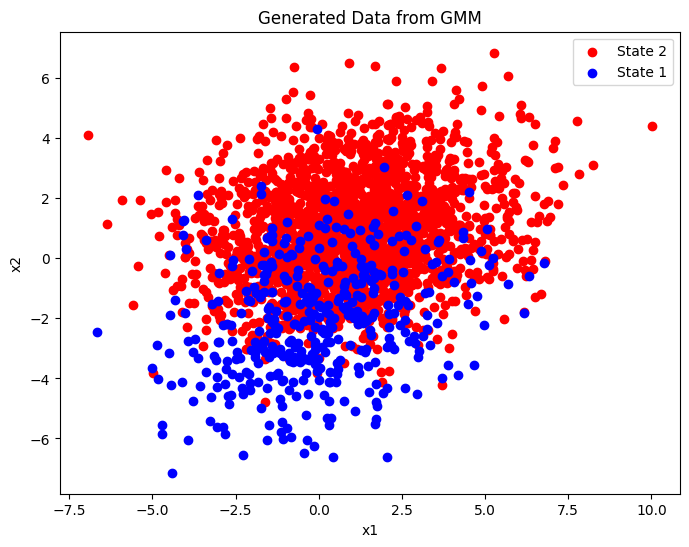

In [2]:

np.random.seed(0)
num_cluster=2
# Create an instance of GaussianHMM with 2 components (states)
model = hmm.GaussianHMM(n_components=num_cluster, covariance_type="full")

# Set the transition matrix
model.transmat_ = np.array([[0.95, 0.05],[0.01, 0.99]])

# Set the initial state distribution
model.startprob_ = np.array([0.6, 0.4])

# Set the means and covariance of each component
model.means_ = np.array([[0, -2], [1, 1]])
model.covars_ = np.array([[[5,1],[1,4]], [[6,1],[1,3]]])

# Generate  samples
data_size=2400
data, labels= model.sample(data_size)


# X contains the generated samples
# Z contains the hidden states

data = np.array(data)
labels = np.array(labels)



# Plot the generated data
plt.figure(figsize=(8, 6))

plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='red', label='State 2')
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='blue', label='State 1')
plt.title('Generated Data from GMM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [3]:
#parameters initialization
#  training sample size
train_size=2000

train_learn_size=1600
#Early stopping and learning criterion

patience = 10
#num_epochs=300
learning_rate=0.001

#parameter initializatio
input_dim=data.shape[1]
hidden_dim=10
depth=2
#lambda_reg=30

output_dim=num_cluster


# Convert the sequence to a suitable shape (input_size=1, sequence_length=T, input_dim)
sequence_origin = data[:train_size]
sequence = torch.tensor(sequence_origin, dtype=torch.float32).view(sequence_origin.shape[0],1, sequence_origin.shape[1])
# Initialize Theta using k-means++
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_cluster, init='k-means++',n_init=10)
theta = kmeans.fit(sequence_origin).cluster_centers_
theta_init = torch.from_numpy(theta).float()


In [5]:
import optuna

# 定义optuna 中目标函数 
def objective(trial,input_dim, hidden_dim, output_dim, depth,data,labels, training_size,theta_initial,learning_rate,patience):
    lambda_reg = trial.suggest_int('lambda_reg', 1, 100)
    num_epochs = trial.suggest_int('num_epochs', 200, 600)

    # Instantiate the model, the model is  DeepBiGRU or DeepGRU
    model = DeepBiGRU(input_dim, hidden_dim, output_dim, depth)
    sequence_origin = data[:training_size]
    sequence = torch.tensor(sequence_origin, dtype=torch.float32).view(sequence_origin.shape[0],1, sequence_origin.shape[1])

    # Instantiate the loss function
    criterion = CustomLoss(lambda_reg,choice ='euclidean',theta=theta_initial)

    model_trained,theta_ite,loss_values, best_loss,outputs = optimize_model(model, criterion, sequence, learning_rate, num_epochs, patience)
    # prediction by machine learning
    sequence_topre = data
    # Convert the sequence to a suitable shape (input_size=1, sequence_length=T, input_dim=15)
    sequence_toprediction = torch.tensor(sequence_topre, dtype=torch.float32).view(sequence_topre.shape[0],1, sequence_topre.shape[1])
    size = data.shape[0] - sequence_origin.shape[0]
    out_pre = model_trained(sequence_toprediction)[-size:]
    data_pre = data[-size:]
    label_onpre = labels[-size:]

    # Get the index of the maximum value in each datapoint
    max_indices_pre = torch.argmax(out_pre, dim=1)
    
    # Convert the tensor of indices to a list
    labels_pre = max_indices_pre.tolist()
    
    bac_pre, perm_pre = max_BAC(label_onpre, labels_pre)
    return bac_pre


from functools import partial

# optimizethe hyoerparameter lamda_reg and num_epoch by  optuna
objective_func = partial(objective, input_dim=input_dim, hidden_dim=hidden_dim, 
                         output_dim=output_dim, depth=depth, data=sequence_origin, labels=labels[:train_size],
                         training_size=train_learn_size,theta_initial=theta_init ,learning_rate=learning_rate, patience=patience)


study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=5)


[I 2023-12-17 21:49:22,073] A new study created in memory with name: no-name-f1079204-0190-46b9-9284-0a7f8c8348de
[I 2023-12-17 21:55:31,718] Trial 0 finished with value: 0.7718050065876152 and parameters: {'lambda_reg': 12, 'num_epochs': 501}. Best is trial 0 with value: 0.7718050065876152.
[I 2023-12-17 22:02:51,694] Trial 1 finished with value: 0.9295125164690382 and parameters: {'lambda_reg': 64, 'num_epochs': 599}. Best is trial 1 with value: 0.9295125164690382.
[I 2023-12-17 22:05:31,175] Trial 2 finished with value: 0.9411067193675889 and parameters: {'lambda_reg': 81, 'num_epochs': 220}. Best is trial 2 with value: 0.9411067193675889.
[I 2023-12-17 22:08:36,031] Trial 3 finished with value: 0.9411067193675889 and parameters: {'lambda_reg': 79, 'num_epochs': 248}. Best is trial 2 with value: 0.9411067193675889.
[I 2023-12-17 22:12:01,772] Trial 4 finished with value: 0.9309617918313571 and parameters: {'lambda_reg': 29, 'num_epochs': 276}. Best is trial 2 with value: 0.941106719

In [15]:
# 获取最佳参数
best_params = study.best_params
lambda_reg = best_params['lambda_reg']
num_epochs = best_params['num_epochs']
print(lambda_reg)

81


In [6]:

# 获取最佳参数
best_params = study.best_params
lambda_reg = best_params['lambda_reg']
num_epochs = best_params['num_epochs']


# Instantiate the model, the model is  DeepBiGRU or DeepGRU
model = DeepBiGRU(input_dim, hidden_dim, output_dim, depth)
# Instantiate the loss function
criterion = CustomLoss(lambda_reg, choice ='euclidean',theta=theta_init)



model, theta_ite,loss_values, best_loss,outputs=optimize_model(model, criterion, sequence,  learning_rate, num_epochs, patience)

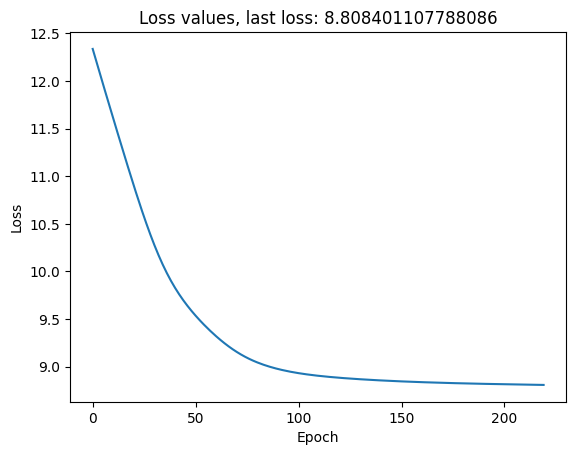

In [8]:
import matplotlib.pyplot as plt

# Create an instance of ModifiedCustomLoss
#modified_loss_function = ModifiedCustomLoss(lambda_reg, num_cluster, choice='euclidean',Theta)
plt.plot(loss_values)
plt.title('Loss values, last loss: ' + str(best_loss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

loss_va, theta_value=criterion(sequence.squeeze(), outputs.squeeze())

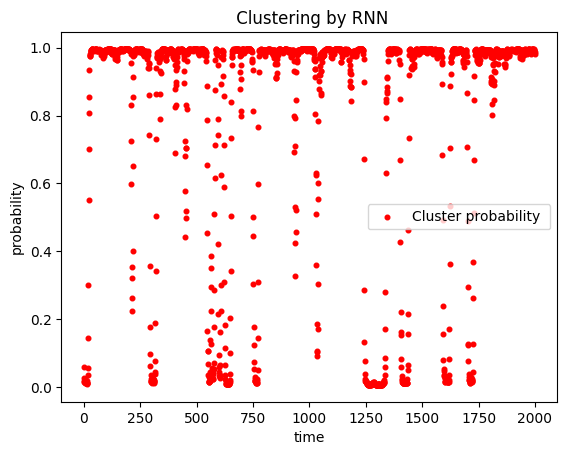

In [9]:
import matplotlib.pyplot as plt

# Define a list of 18 colors
colors = ['red', 'green']



# Convert the outputs to numpy array
outputs_np = outputs.detach().numpy()

# Plot the data points with different colors for different clusters

plt.scatter(range(sequence_origin.shape[0]), outputs_np[:, 0], color=colors[0], label='Cluster probability ', alpha=1, s=11)


# Add labels and title
plt.xlabel('time')
plt.ylabel('probability')
plt.title(' Clustering by RNN')
plt.legend()

# Show the plot
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Balanced Accuracy on the training data: 0.952943722943723
trained cluster center [[0.9995642900466919, 0.8877668976783752], [-0.09863662719726562, -1.362865924835205]]


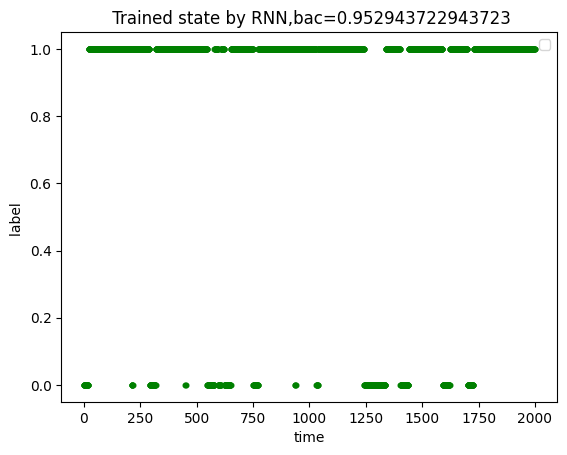

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


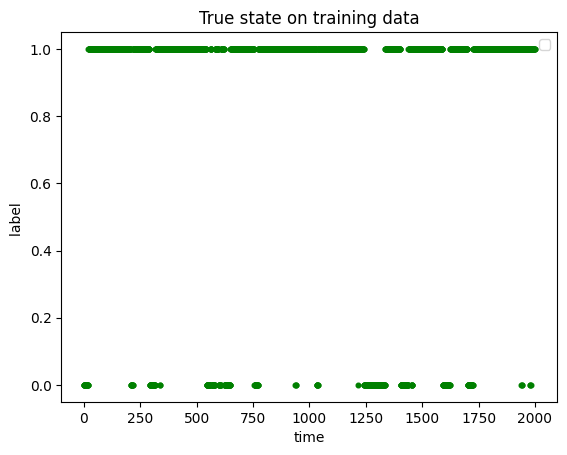

In [10]:
from sklearn.metrics import balanced_accuracy_score

# Get the index of the maximum value in each datapoint
max_indices = torch.argmax(outputs, dim=1)

# Convert the tensor of indices to a list
labels_train = max_indices.tolist()

bac_train,perm_train=max_BAC(labels[:train_size],labels_train)


print('Balanced Accuracy on the training data:', bac_train)

print('trained cluster center', theta_ite.tolist())


permutate_labels_train=permutation_label(labels_train,perm_train)


plt.scatter(range(sequence_origin.shape[0]), permutate_labels_train,color=colors[1], alpha=1, s=11)
# Add labels and title
plt.xlabel('time')
plt.ylabel('label ')
plt.title(' Trained state by RNN,bac='+ str(bac_train) )
plt.legend()

# Show the plot
plt.show()


plt.scatter(range(sequence_origin.shape[0]), labels[:train_size],color=colors[1], alpha=1, s=11)
# Add labels and title
plt.xlabel('time')
plt.ylabel('label ')
plt.title('True state on training data')
plt.legend()

# Show the plot
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Balanced Accuracy on the training data by kmeans++: 0.6754112554112555


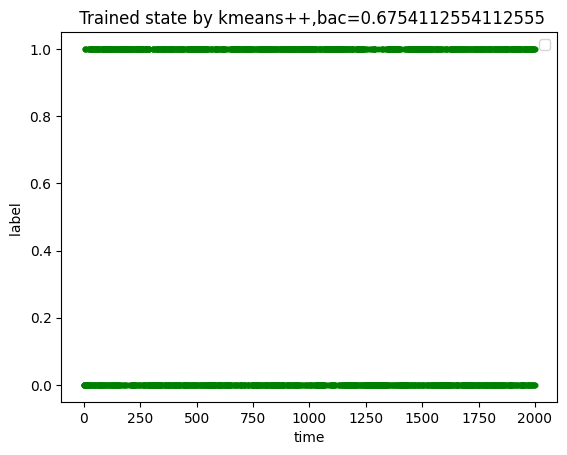

In [11]:
from itertools import permutations
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

# Predict the labels for the original sequence
labels_kmeans = kmeans.predict(sequence_origin)

bac_kmeans,perm_kmeans=max_BAC(labels[:train_size], labels_kmeans)

print('Balanced Accuracy on the training data by kmeans++:', bac_kmeans)

permutate_labels_kmeans=permutation_label(labels_kmeans,perm_kmeans)


plt.scatter(range(sequence_origin.shape[0]), permutate_labels_kmeans,color=colors[1], alpha=1, s=11)
# Add labels and title
plt.xlabel('time')
plt.ylabel('label ')
plt.title(' Trained state by kmeans++,bac='+ str(bac_kmeans) )
plt.legend()

# Show the plot
plt.show()




In [14]:
from hmmlearn import hmm
import numpy as np

average_bac_hmm, var_bac_hmm=calculate_bac_hmm(sequence_origin,labels[:train_size],num_cluster,100)
print('average Balanced Accuracy on the training data by HMM',average_bac_hmm)

print('variance of  Balanced Accuracy on the training data by HMM', var_bac_hmm)




average Balanced Accuracy on the training data by HMM 0.7284619047619049
variance of  Balanced Accuracy on the training data by HMM 0.03919557390060157


Balanced Accuracy on the testing data: 0.9984894259818731


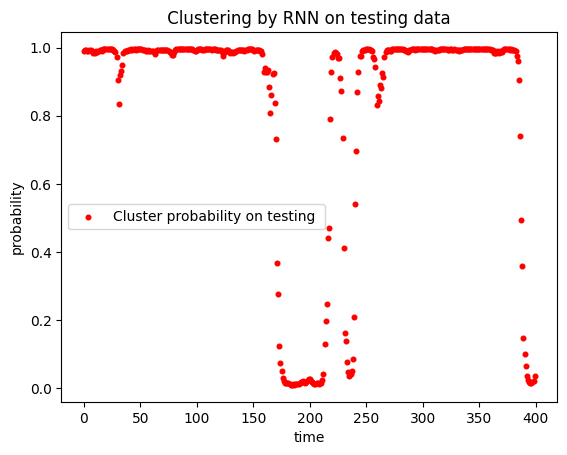

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


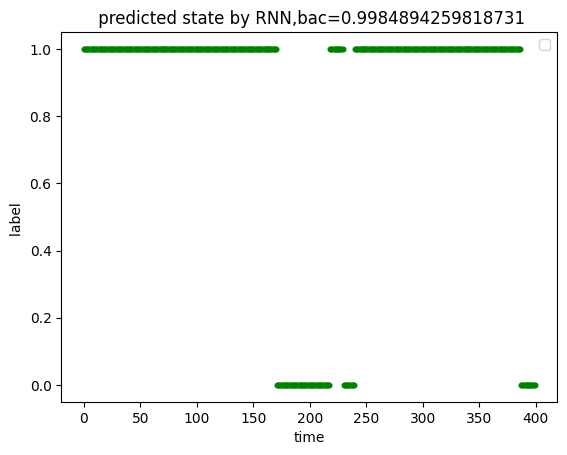

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


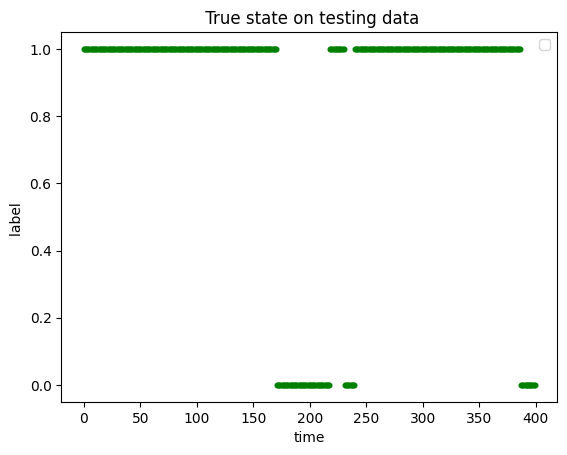

In [16]:
# prediction by machine learning
sequence_topre = data
# Convert the sequence to a suitable shape (input_size=1, sequence_length=T, input_dim=15)
sequence_toprediction = torch.tensor(sequence_topre, dtype=torch.float32).view(sequence_topre.shape[0],1, sequence_topre.shape[1])
size=data.shape[0]-sequence_origin.shape[0]
out_pre= model(sequence_toprediction)[-size:]
data_pre=data[-size:]

# Get the index of the maximum value in each datapoint
max_indices_pre = torch.argmax(out_pre, dim=1)

# Convert the tensor of indices to a list
labels_pre = max_indices_pre.tolist()

bac_pre,perm_pre = max_BAC(labels[-size:], labels_pre )

print('Balanced Accuracy on the testing data:', bac_pre)

# Convert the outputs to numpy array
out_pre_np = out_pre.detach().numpy()

plt.scatter(range(size), out_pre_np[:, 0], color=colors[0], label='Cluster probability on testing ', alpha=1, s=11)


# Add labels and title
plt.xlabel('time')
plt.ylabel('probability')
plt.title(' Clustering by RNN on testing data ')
plt.legend()

# Show the plot
plt.show()


permutate_labels_pre=permutation_label(labels_pre,perm_pre)


plt.scatter(range(size), permutate_labels_pre,color=colors[1], alpha=1, s=11)
# Add labels and title
plt.xlabel('time')
plt.ylabel('label ')
plt.title(' predicted state by RNN,bac='+ str(bac_pre) )
plt.legend()

# Show the plot
plt.show()

plt.scatter(range(size), labels[-size:],color=colors[1], alpha=1, s=11)
# Add labels and title
plt.xlabel('time')
plt.ylabel('label ')
plt.title(' True state on testing data')
plt.legend()

# Show the plot
plt.show()
